# Blindness Detection 

## Multiclass Classification

## 1. Setup

In [1]:
import re
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121

In [2]:
img_dir = "train_images/"

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
IMAGE_SIZE = [320, 320]
SEED = 42

## 2. Load Data

In [3]:
df = pd.read_csv("train.csv")

df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [4]:
# split dataset into train, val and test set

train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.2, random_state=SEED)

In [5]:
# train set
# construct a dataset with image paths and labels

imagePaths = train_df.apply(lambda x : img_dir + str(x[0]) + ".png", axis=1).values

labels = train_df.iloc[:, -1].values

train_ds = tf.data.Dataset.from_tensor_slices((imagePaths, labels))

In [6]:
# validation set

imagePaths = val_df.apply(lambda x : img_dir + str(x[0]) + ".png", axis=1).values

labels = val_df.iloc[:, -1].values

val_ds = tf.data.Dataset.from_tensor_slices((imagePaths, labels))

In [7]:
# list of image paths from train dataset

for f in train_ds.take(5):
    print(f[0].numpy())

b'train_images/b2b79b37d314.png'
b'train_images/175dd560810a.png'
b'train_images/c3cd0200df79.png'
b'train_images/cfed7c1172ec.png'
b'train_images/e811f39a1243.png'


In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
print("Training images count: ", str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
print("Validating images count: ", str(VAL_IMG_COUNT))

Training images count:  2929
Validating images count:  733


In [9]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.

def get_label(label):
    return tf.one_hot(label, 5)

def decode_img(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.image.resize(image, IMAGE_SIZE)

def preprocess(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    label = get_label(label)
    return image, label

In [10]:
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (320, 320, 3)
Label:  [1. 0. 0. 0. 0.]


In [12]:
def augment(image):
    
    image = tf.image.random_contrast(image, 0.75, 1.25)
    image = tf.image.random_saturation(image, 0.75, 1.25)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=2)

    return image

In [13]:
def prepare_for_training(ds, augmentation=False):
    
    if augmentation:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size=BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [14]:
train_ds = prepare_for_training(train_ds, augmentation=True)
val_ds = prepare_for_training(val_ds)

## 3. Visualize the dataset

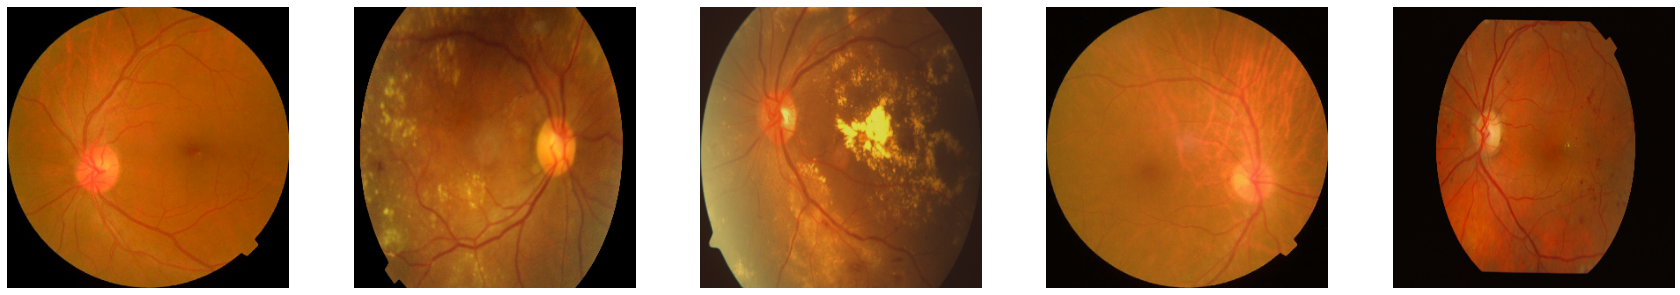

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch):
    plt.figure(figsize=(30, 30))
    for n in range(5):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.axis("off")
        
show_batch(image_batch.numpy())

## 4. Build the CNN

In [17]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model-dr.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

lr_plateau_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

In [18]:
callbacks = [checkpoint_cb, early_stopping_cb, lr_plateau_cb]

## 5. Measure to cope with data imbalance

In [19]:
no_dr, mild, moderate, severe, dr = np.bincount(df['diagnosis'])
total = no_dr + mild + moderate + severe + dr

weight_for_0 = (1 / no_dr) * (total) / 2.0 
weight_for_1 = (1 / mild) * (total) / 2.0
weight_for_2 = (1 / moderate) * (total) / 2.0 
weight_for_3 = (1 / severe) * (total) / 2.0
weight_for_4 = (1 / dr) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 1.01
Weight for class 1: 4.95
Weight for class 2: 1.83
Weight for class 3: 9.49
Weight for class 4: 6.21


## 6. Train the model

In [20]:
def build_model():

    model = tf.keras.Sequential([
        DenseNet121(input_shape=(320, 320, 3), weights="imagenet", include_top=False),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation="elu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation="softmax")
    ])
     
    return model

In [21]:
model = build_model()

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-4),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"],
    )

29089792/29084464 [==============================] - 0s 0us/step


In [22]:
history = model.fit(train_ds,
                    epochs = 30,
                    validation_data = val_ds,
                    callbacks = callbacks,
                    class_weight = class_weight,
                    verbose = 1,
                    initial_epoch = 0)

Epoch 1/30
367/367 [==============================] - 427s 1s/step - loss: 3.5127 - accuracy: 0.5504 - val_loss: 0.6956 - val_accuracy: 0.7381
Epoch 2/30
367/367 [==============================] - 406s 1s/step - loss: 2.9144 - accuracy: 0.6596 - val_loss: 0.6606 - val_accuracy: 0.7490
Epoch 3/30
367/367 [==============================] - 363s 989ms/step - loss: 2.5328 - accuracy: 0.7026 - val_loss: 1.0046 - val_accuracy: 0.5894
Epoch 4/30
367/367 [==============================] - 361s 984ms/step - loss: 2.3369 - accuracy: 0.7180 - val_loss: 0.7040 - val_accuracy: 0.7490
Epoch 5/30
367/367 [==============================] - 360s 981ms/step - loss: 2.1996 - accuracy: 0.7398 - val_loss: 0.5875 - val_accuracy: 0.7653
Epoch 6/30
367/367 [==============================] - 361s 985ms/step - loss: 2.0716 - accuracy: 0.7555 - val_loss: 0.5935 - val_accuracy: 0.8090
Epoch 7/30
367/367 [==============================] - 359s 979ms/step - loss: 1.8839 - accuracy: 0.7897 - val_loss: 0.6241 - val_a

In [24]:
# saving the model

model.save("model.h5")

## 8. Visualizing model performance

In [23]:
def plot(hist):
    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax = ax.ravel()
    for i, metric in enumerate(['loss', 'accuracy']):
        ax[i].plot(hist.history[metric])
        ax[i].plot(hist.history['val_' + metric])
        ax[i].set_title('Model {}'.format(metric), fontsize=20)
        ax[i].set_xlabel('epochs', fontsize=16)
        ax[i].set_ylabel(metric, fontsize=16)
        ax[i].legend(['train', 'val'])

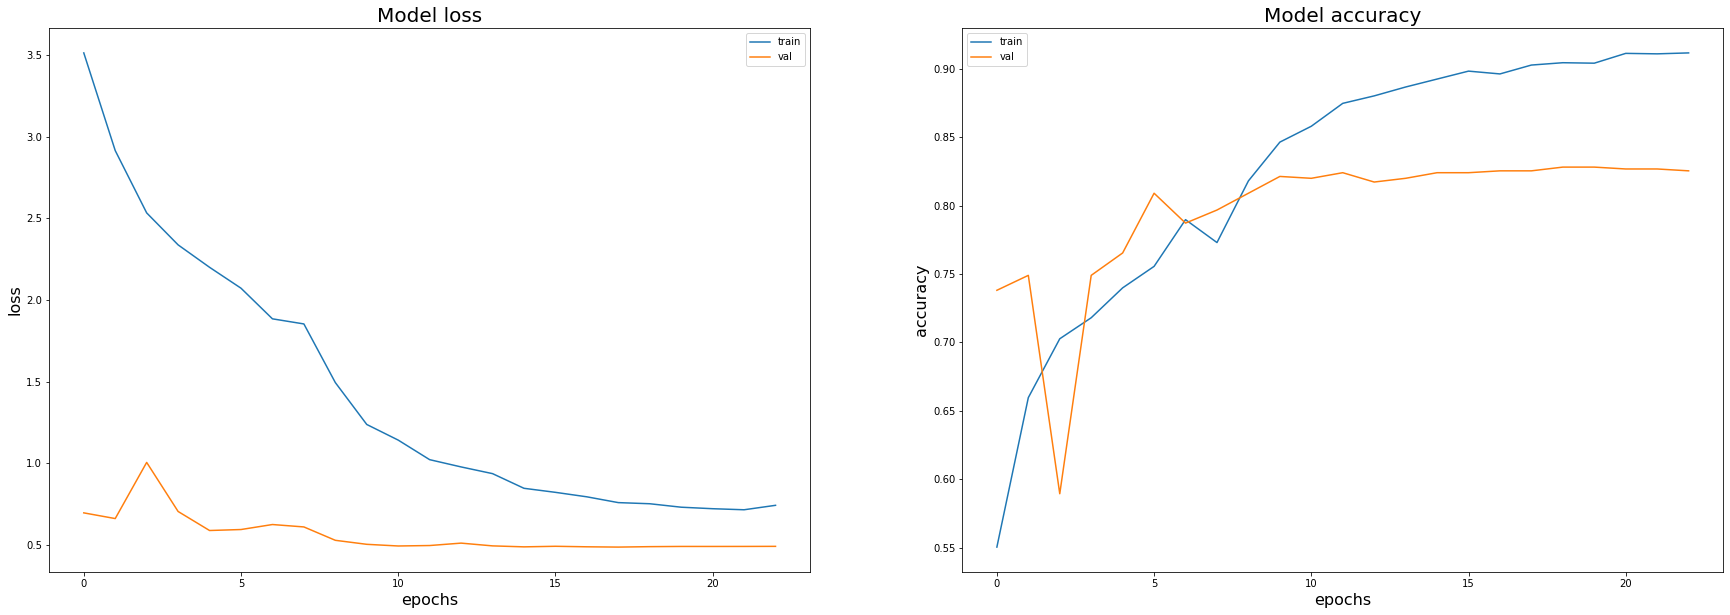

In [25]:
plot(history)

In [26]:
def plot_confusion_matrix(y, y_pred):
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Quadratic Weighted Kappa:  0.9565779678157756


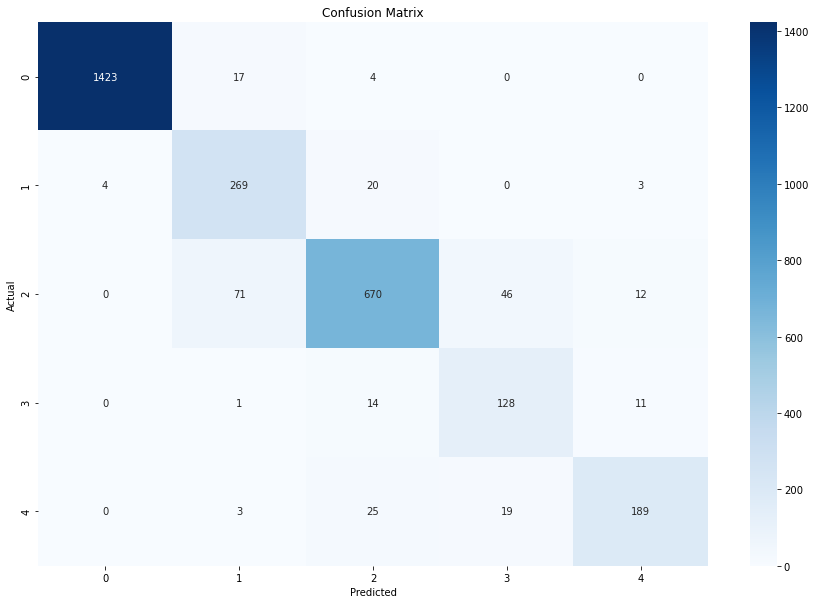

In [27]:
# train set

y = train_df["diagnosis"].values

y_pred = [np.argmax(pred) for pred in model.predict(train_ds)]

score = cohen_kappa_score(y, y_pred, weights='quadratic')
print('Quadratic Weighted Kappa: ', score)

plot_confusion_matrix(y, y_pred)

## 9. Predict and evaluate results

In [16]:
model = tf.keras.models.load_model("model.h5")

In [29]:
loss, acc = model.evaluate(val_ds)

92/92 [==============================] - 69s 747ms/step - loss: 0.4859 - accuracy: 0.8254


Quadratic Weighted Kappa:  0.8740605929480041


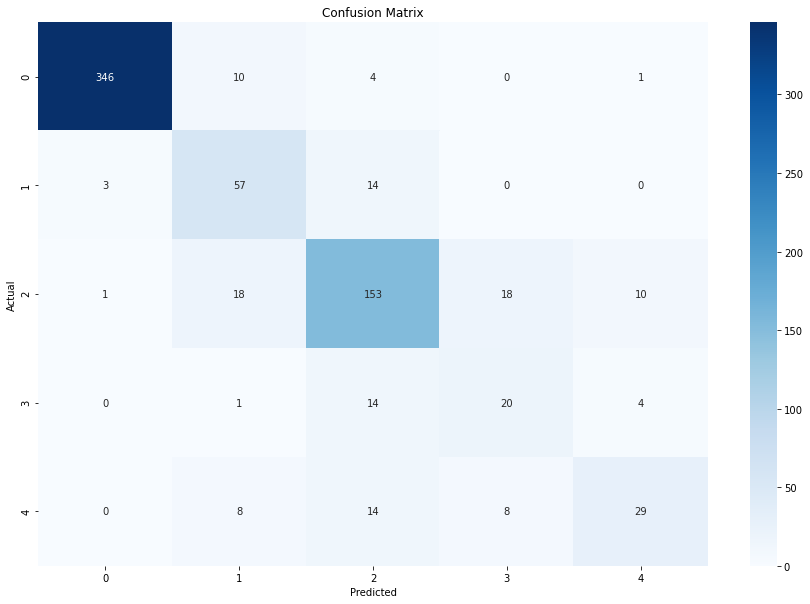

In [31]:
y = val_df["diagnosis"].values

y_pred = [np.argmax(pred) for pred in model.predict(val_ds)]

score = cohen_kappa_score(y, y_pred, weights='quadratic')
print('Quadratic Weighted Kappa: ', score)

plot_confusion_matrix(y, y_pred)

## 10. Error Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0ccecae90>]],
      dtype=object)

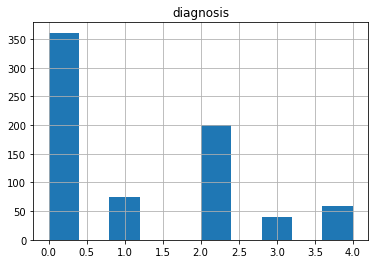

In [30]:
# validation set
val_df.hist()

These are the number of images and their DR severity grade according to different classes they belong to. We can then analyse the predicted and actual label using the confusion matrix.

These values give us the sensitivity and specificity values for each classes and the overall accuracy

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       361
           1       0.61      0.77      0.68        74
           2       0.77      0.77      0.77       200
           3       0.43      0.51      0.47        39
           4       0.66      0.49      0.56        59

    accuracy                           0.83       733
   macro avg       0.69      0.70      0.69       733
weighted avg       0.83      0.83      0.83       733



- As we can see the F1-score of class 0 and 2 is high whereas that of other classes is low. Our model is misclassifying these classes and correctly predicting class 0 and 2
- Class 3 is highly misclassified. Most of the values from class 3 are getting predicted as class 2 and 4.

<h2>Visualize images with actual and predicted labels</h2>

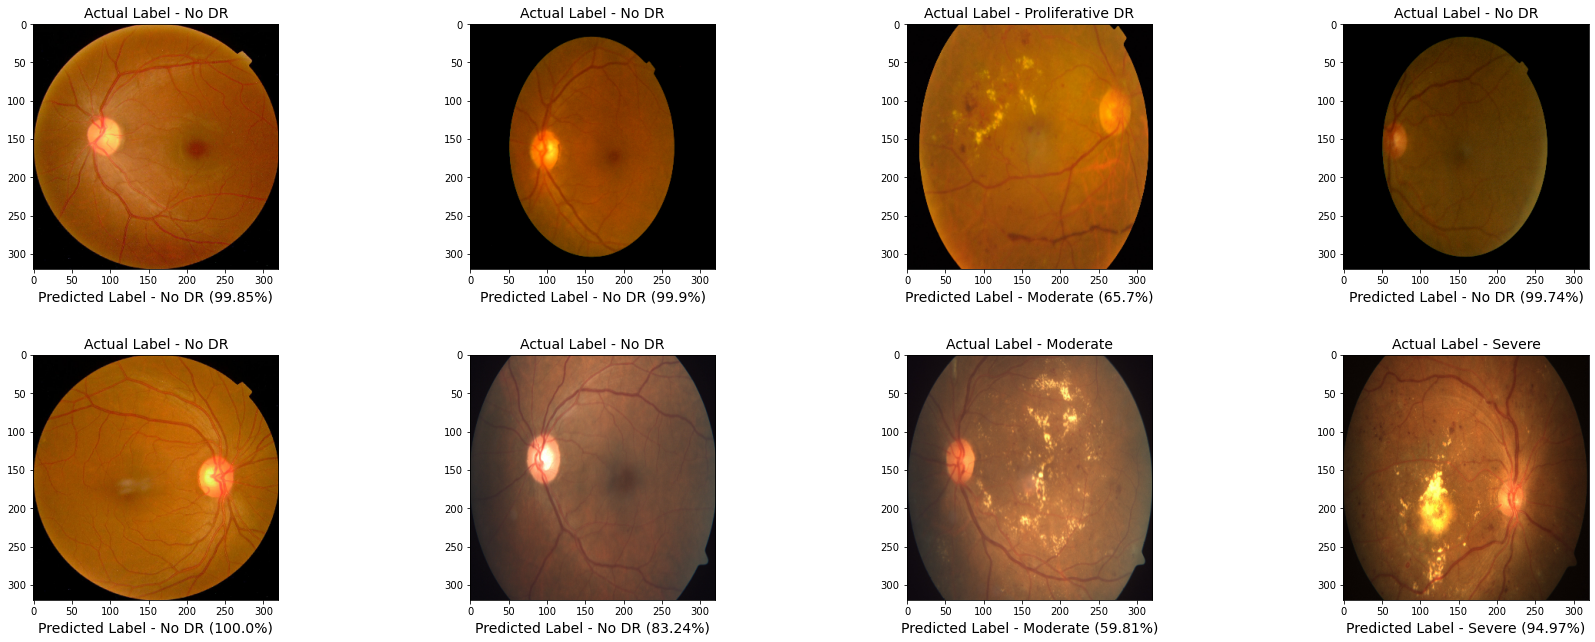

In [33]:
CLASS_NAMES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

for image, label in val_ds.take(1):

    plt.figure(figsize=(30, 10))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(image[i])
        actual_label = "Actual Label - " + CLASS_NAMES[np.argmax(label[i].numpy())]
        plt.title(actual_label, fontsize=14)
        prediction = model.predict(val_ds.take(1))[i]
        number = str(round(100 * prediction[np.argmax(prediction)], 2))
        predicted_label = "Predicted Label - " + CLASS_NAMES[np.argmax(prediction)] + " (" + number + "%)"
        plt.xlabel(predicted_label, fontsize=14)

        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

These are some images with their actual and predicted label with probability score of prediction. Patients with no diabetic retinopathy are getting classified correctly with high score but the patients severe DR are getting misclassified which is concerning.

<h2>Analyze misclassified datapoints</h2>

For example, Which are predicted as 2 but actual labels are 1, 3 and 4

In [104]:
df = pd.DataFrame(data={'id_code': val_df['id_code'].values, 'actual': y, 'predicted': y_pred})

<h3>Analyzing images that are predicted as class 1 but thy belong to class 2</h3>

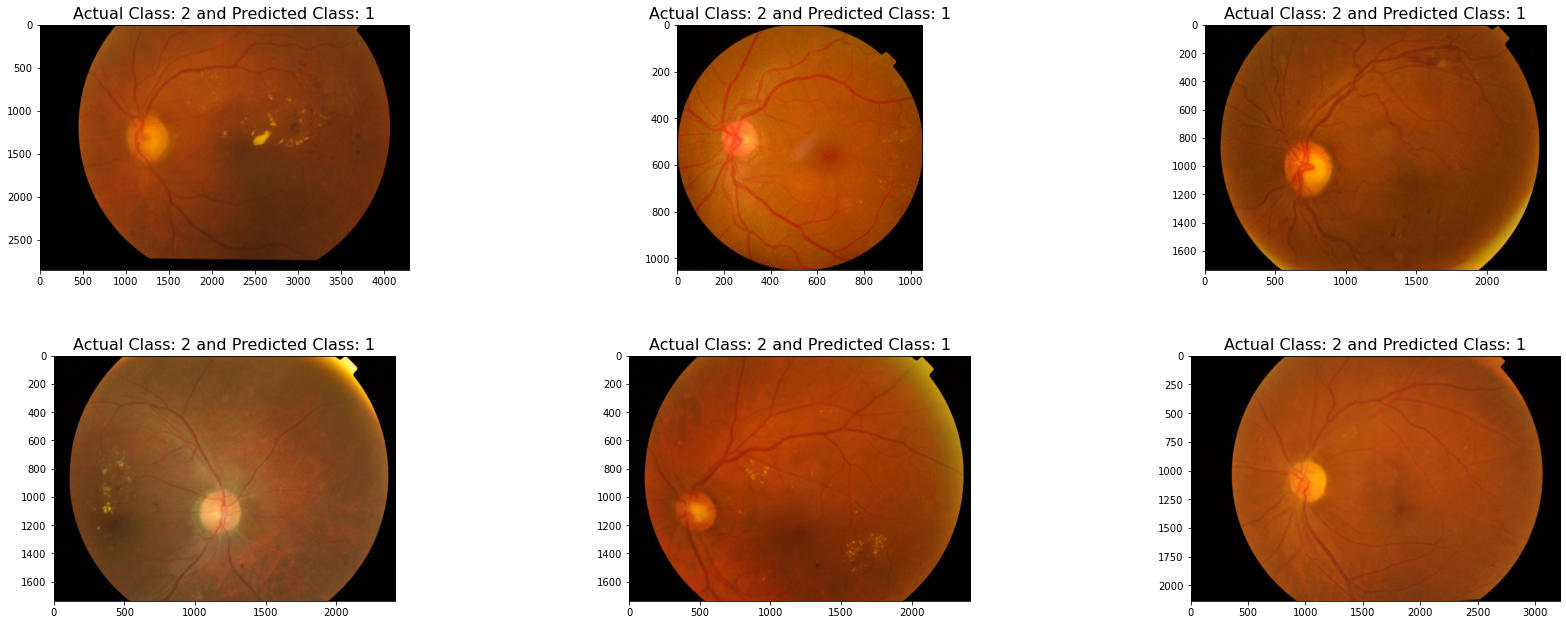

In [167]:
ex = df.loc[(df['predicted'] == 1) & (df['actual'] == 2)][:6]

plt.figure(figsize=(30, 10))
i = 0
for index, row in ex.iterrows():
    
    if (i < 6):
        plt.subplot(2, 3, i + 1)
        path = "train_images/" + row['id_code'] + ".png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.title("Actual Class: " + str(row['actual']) + " and " + \
                  "Predicted Class: " + str(row['predicted']), fontsize=16)
        plt.imshow(image)

        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.1, 
                            hspace=0.35)

        i = i + 1

<h3>Analyzing images that are predicted as class 2 but thy belong to class 1</h3>

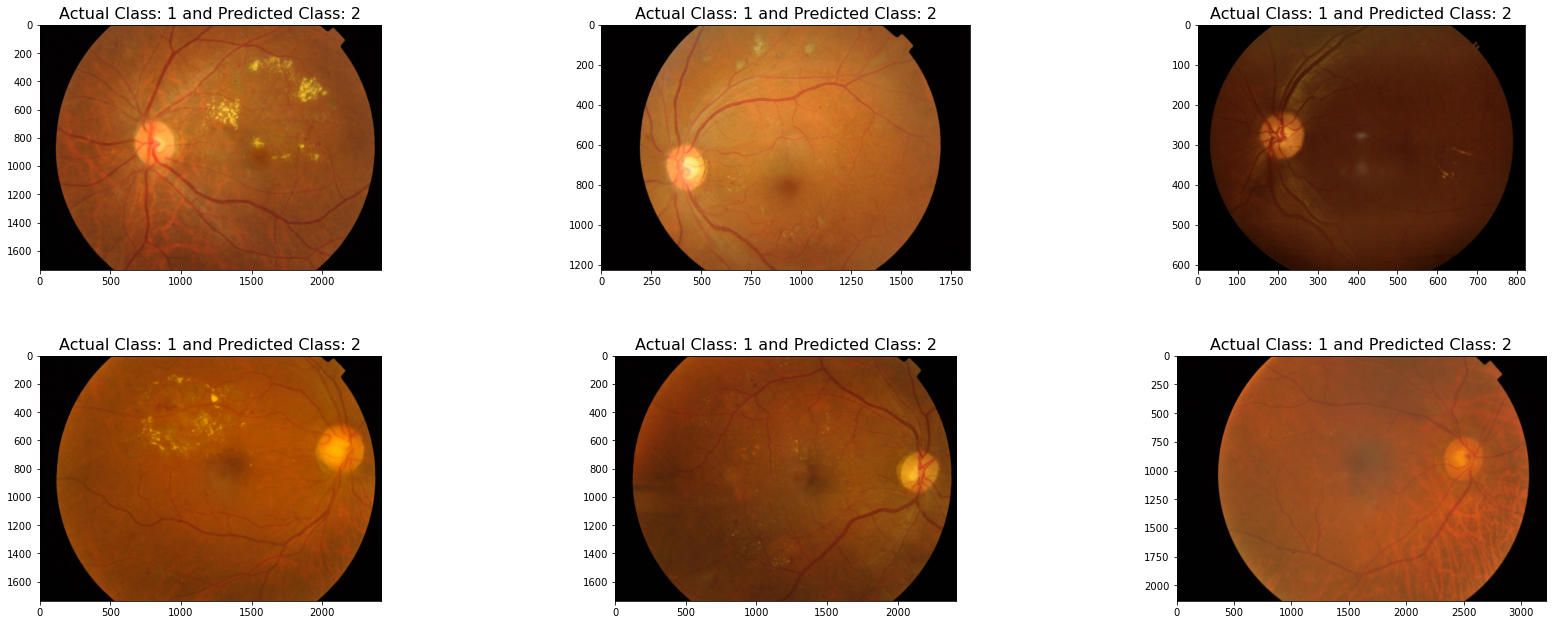

In [173]:
ex = df.loc[(df['predicted'] == 2) & (df['actual'] == 1)][:6]

plt.figure(figsize=(30, 10))
i = 0
for index, row in ex.iterrows():
    
    if (i < 6):
        plt.subplot(2, 3, i + 1)
        path = "train_images/" + row['id_code'] + ".png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.title("Actual Class: " + str(row['actual']) + " and " + \
                  "Predicted Class: " + str(row['predicted']), fontsize=16)
        plt.imshow(image)

        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.1, 
                            hspace=0.35)

        i = i + 1

These images are classified as class 2 which is mild whereas the actual class they belong to is class 1 which is No DR. This is not a issue as further tests will only confirm that the patient does not have DR.

<h3>Analyzing images that are predicted as class 2 but thy belong to class 3</h3>

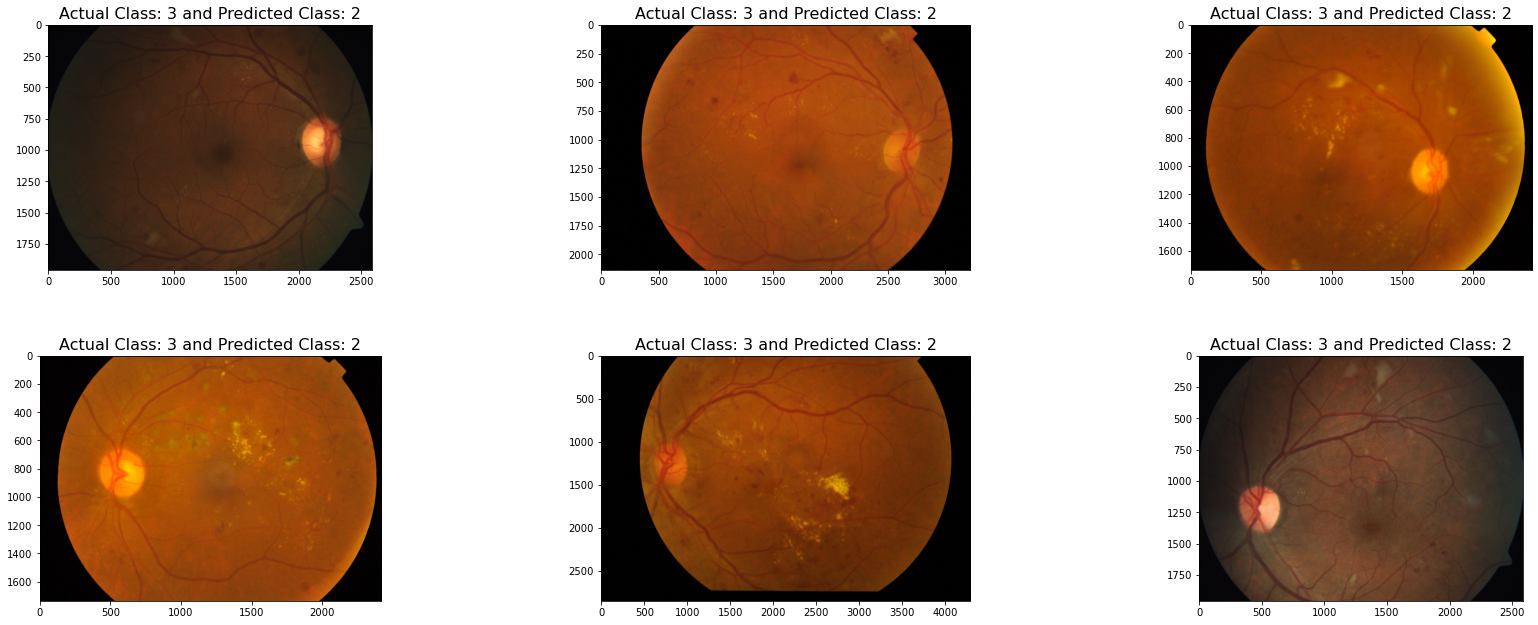

In [169]:
ex = df.loc[(df['predicted'] == 2) & (df['actual'] == 3)][:6]

plt.figure(figsize=(30, 10))
i = 0
for index, row in ex.iterrows():
    
    if (i < 6):
        plt.subplot(2, 3, i + 1)
        path = "train_images/" + row['id_code'] + ".png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.title("Actual Class: " + str(row['actual']) + " and " + \
                  "Predicted Class: " + str(row['predicted']), fontsize=16)
        plt.imshow(image)

        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.1, 
                            hspace=0.35)

        i = i + 1

<h3>Analyzing images that are predicted as class 2 but thy belong to class 4</h3>

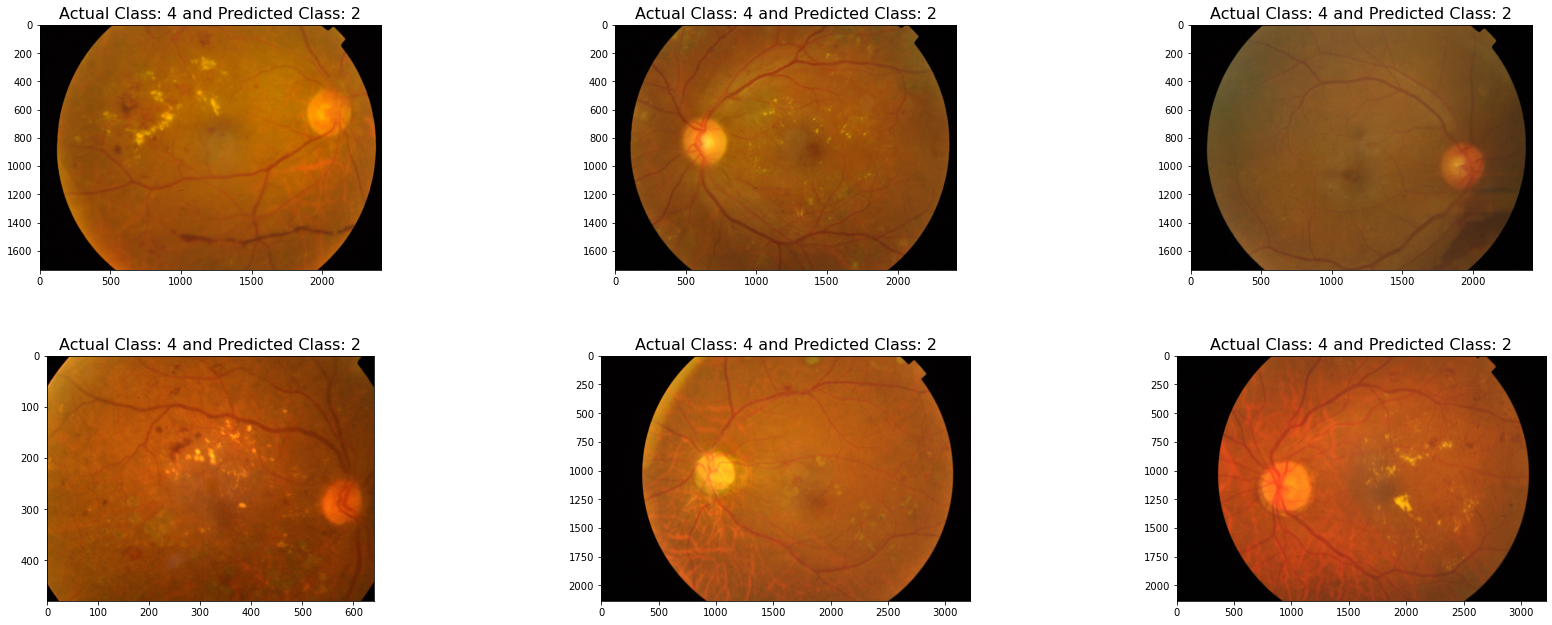

In [170]:
ex = df.loc[(df['predicted'] == 2) & (df['actual'] == 4)][:6]

plt.figure(figsize=(30, 10))
i = 0
for index, row in ex.iterrows():
    
    if (i < 6):
        plt.subplot(2, 3, i + 1)
        path = "train_images/" + row['id_code'] + ".png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.title("Actual Class: " + str(row['actual']) + " and " + \
                  "Predicted Class: " + str(row['predicted']), fontsize=16)
        plt.imshow(image)

        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.1, 
                            hspace=0.35)

        i = i + 1

- These images are classified as class 2 which is mild whereas the actual class they belong to is class 4 which is Proliferative DR which is the the most severe case. This is a concern for us as these cases may go unnoticed and the patient may suffer.
- The cases where predicted label is the severe case of DR is concerning. We have to improve our model to detect these cases correctly otherwise it may prove fatal.

<h2>Visualize images with labels and model score for each label</h2>

Actual Label - Proliferative DR
Predicted Label - Moderate


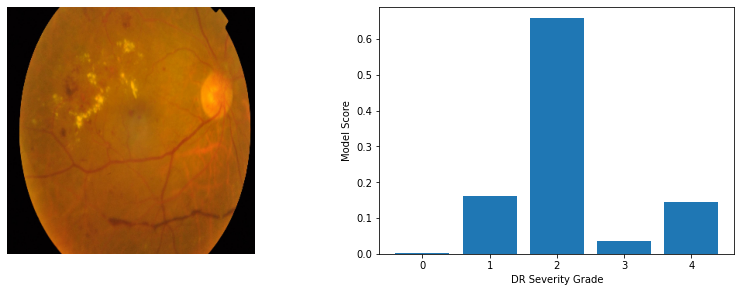

In [34]:
CLASS_NAMES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

for image, label in val_ds.take(1):

    i = 2

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image[i])
    plt.axis("off")

    actual_label = "Actual Label - " + CLASS_NAMES[np.argmax(label[i].numpy())]
    print(actual_label)

    prediction = model.predict(val_ds.take(1))[i]    
    number = str(round(100 * prediction[np.argmax(prediction)], 2))
    predicted_label = "Predicted Label - " + CLASS_NAMES[np.argmax(prediction)]
    print(predicted_label)


    plt.subplot(2, 2, 2)
    plt.bar(np.arange(len(prediction)), prediction)
    plt.xlabel("DR Severity Grade")
    plt.ylabel("Model Score")
    plt.show()

Actual Label - No DR
Predicted Label - No DR


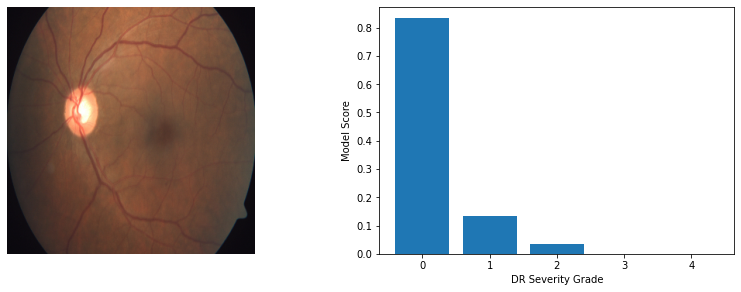

In [35]:
CLASS_NAMES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

for image, label in val_ds.take(1):

    i = 5

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image[i])
    plt.axis("off")

    actual_label = "Actual Label - " + CLASS_NAMES[np.argmax(label[i].numpy())]
    print(actual_label)

    prediction = model.predict(val_ds.take(1))[i]    
    number = str(round(100 * prediction[np.argmax(prediction)], 2))
    predicted_label = "Predicted Label - " + CLASS_NAMES[np.argmax(prediction)]
    print(predicted_label)


    plt.subplot(2, 2, 2)
    plt.bar(np.arange(len(prediction)), prediction)
    plt.xlabel("DR Severity Grade")
    plt.ylabel("Model Score")
    plt.show()

Actual Label - Severe
Predicted Label - Severe


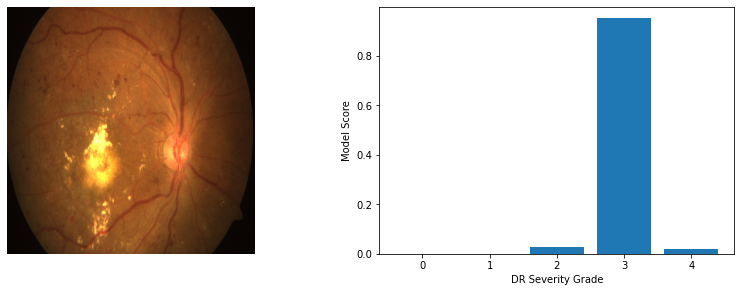

In [28]:
CLASS_NAMES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

for image, label in val_ds.take(1):

    i = 7

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image[i])
    plt.axis("off")

    actual_label = "Actual Label - " + CLASS_NAMES[np.argmax(label[i].numpy())]
    print(actual_label)

    prediction = model.predict(val_ds.take(1))[i]    
    number = str(round(100 * prediction[np.argmax(prediction)], 2))
    predicted_label = "Predicted Label - " + CLASS_NAMES[np.argmax(prediction)]
    print(predicted_label)


    plt.subplot(2, 2, 2)
    plt.bar(np.arange(len(prediction)), prediction)
    plt.xlabel("DR Severity Grade")
    plt.ylabel("Model Score")
    plt.show()

# Conclusions

- Our model is correctly predicting patients with No DR whereas there are concerns with other types of conditions
- Less number of images with highly imbalanced data should be the cause of such performance issues
- Cropping of images can prove beneficial
- Our model failed to learn the small details in the images for detecting severe DR such as hemorrhages

<h2>Final function for the inference</h2>

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
LABELS = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
BATCH_SIZE = 8
IMAGE_SIZE = [320, 320]

def final_func_1(image_path):

    def decode_img(image):
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        return tf.image.resize(image, IMAGE_SIZE)

    def preprocess(image):
        image = tf.io.read_file(image)
        image = decode_img(image)
        return image
    
    image = list(tf.data.Dataset.list_files(image_path))

    ds = tf.data.Dataset.from_tensor_slices(image)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)

    model = tf.keras.models.load_model("model.h5")

    prediction = model.predict(ds)
    
    number = str(round(100 * prediction[0][np.argmax(prediction[0])], 2))
    predicted_label = f"This image is {number}% {LABELS[np.argmax(prediction)]}"
    
    print(predicted_label)
    
    plt.subplot(1, 1, 1)
    plt.bar(np.arange(len(prediction[0])), prediction[0])
    plt.xlabel("DR Severity Grade")
    plt.ylabel("Model Score")
    plt.show()

<h2>Results of inference</h2>

This image is 65.7% Moderate


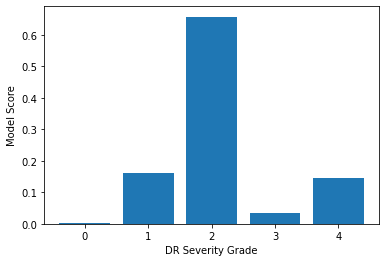

In [4]:
final_func_1("train_images/61bbc11fe503.png")

This image is 99.74% No DR


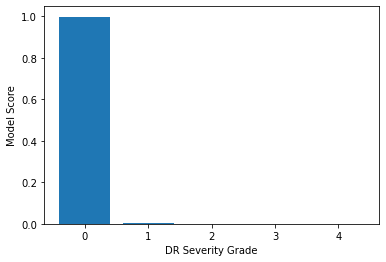

In [9]:
final_func_1("train_images/60edda7b4871.png")

This image is 96.94% Moderate


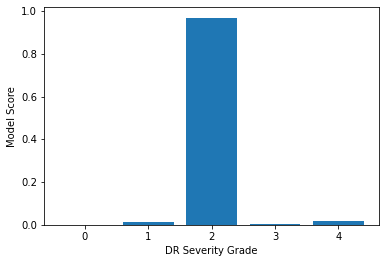

In [10]:
final_func_1("train_images/a3b2e93d058b.png")

In [ ]:
##

In [ ]:
##